In [1]:
import platform

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import matplotlib
from matplotlib import pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

print(f"""
Python: {platform.python_version()} 
Tensorflow: {tf.__version__}
Numpy: {np.__version__}
Matplotlib: {matplotlib.__version__}
""")



Python: 3.8.8 
Tensorflow: 2.6.0
Numpy: 1.19.5
Matplotlib: 3.4.3



# Knowledge Distillation
### Model compression method in which a small model is trained to mimic a pre-trained, larger model
- Typically has a teacher model and a student model

![KD Model Image](https://nni.readthedocs.io/en/latest/_images/distill.png)




# Defining a teacher model
![Teacher Model](teacher.png)

| Layer (type) 	| Output Shape        	| Param # 	|
|--------------	|---------------------	|---------	|
| Conv2D       	| (None, 14, 14, 256) 	| 2560    	|
| LeakyReLU    	| (None, 14, 14, 256) 	| 0       	|
| MaxPooling2D 	| (None, 14, 14, 256) 	| 0       	|
| Conv2D       	| (None, 7, 7, 512)   	| 1180160 	|
| Flatten      	| (None, 25088)       	| 0       	|
| Dense        	| (None, 10)          	| 250890  	|


In [2]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="teacher",
)

In [3]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 256)       2560      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 512)         1180160   
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                250890    
Total params: 1,433,610
Trainable params: 1,433,610
Non-trainable params: 0
_________________________________________________

# Defining a student model
![Student Model](student.png)

| Layer (type) 	| Output Shape        	| Param # 	|
|--------------	|---------------------	|---------	|
| Conv2D       	| (None, 14, 14, 16) 	| 160    	|
| LeakyReLU    	| (None, 14, 14, 16) 	| 0       	|
| MaxPooling2D 	| (None, 14, 14, 16) 	| 0       	|
| Conv2D       	| (None, 7, 7, 32)   	| 4640 		|
| Flatten      	| (None, 1568)       	| 0       	|
| Dense        	| (None, 10)          	| 15690  	|

In [5]:
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="student",
)
# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [6]:
student.summary()

Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                15690     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_______________________________________________________

# Distiller


## Distiller trains student model using teachers output and hard label
![KD Model Image](KDLoss.png)

## Lets take a look at the loss Fns

### There are two losses

- #### student_loss
    - Student loss is a simple loss function comparing predictions and output
    - SparseCategoricalLoss https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
- #### distillation_loss
    - Distillation loss is a Kullback-Leibler(KL) divergence between teacher's prediction and student's prediction
    - https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence
    - Softmax & Temperature (T) Scaling factor
       $$ \sigma(z,T) = \frac{e^{z_i / T} }{ \Sigma_j e^{z_j / T} }  $$
        - Smoothes output (smaller inputs have bigger output and big inputs have smaller output)

![Temperature](https://www.researchgate.net/publication/325016605/figure/fig1/AS:635391270977537@1528500492783/An-example-of-categorical-probability-distributions-of-high-temperature-softmax-output.png)

### Combination of the losses

$$ 
\text{total_loss} = 
\alpha \cdot \text{student_loss(} 
        \hat{y}_{student}, y 
    \text{ )} + 
(1-\alpha) \cdot \text{distillation_loss(} 
        \sigma(\hat{y}_{student},T), \sigma(\hat{y}_{teacher},T) 
    \text{)} 
$$

In [10]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self,optimizer, metrics, student_loss_fn,distillation_loss_fn, alpha=0.1, temperature=3):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            
            ### TODO Start ###
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
            
            
            ### TODO END ###

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

# Preparing MNIST Dataset

![MNIST Dataset](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

In [11]:
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Training Teacher Model
## Teacher model is usually pretrained / robust 

### Since MNIST dataset is easy to predict, teacher model will only train for 1 epoch

In [9]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=1, use_multiprocessing=True)
teacher.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9732


[0.08747038245201111, 0.9732000231742859]

# Distiller / Training Student Model
- ## We have a strong teacher model capable of predicting MNIST
- ## Instantiate distiller and train student model

In [12]:
# Initialize and compile distiller

### TODO START ###
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)
### TODO END ###

# Distill teacher to student
student_history = distiller.fit(x_train, y_train, epochs=3)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 3s 1ms/step - sparse_categorical_accuracy: 0.9295 - student_loss: 0.2377 - distillation_loss: 0.0347
Epoch 2/3
1875/1875 [==============================] - 3s 1ms/step - sparse_categorical_accuracy: 0.9750 - student_loss: 0.0826 - distillation_loss: 0.0080
Epoch 3/3
313/313 [==============================] - 0s 702us/step - sparse_categorical_accuracy: 0.9787 - student_loss: 0.0658


[0.9786999821662903, 0.0012690321309491992]

In [13]:
# Train student as done usually
student_scratch.compile (
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
student_scratch_history = student_scratch.fit(x_train, y_train, epochs=3)
student_scratch.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 [==============================] - 2s 895us/step - loss: 0.2429 - sparse_categorical_accuracy: 0.9270
Epoch 2/3
1875/1875 [==============================] - 2s 894us/step - loss: 0.0920 - sparse_categorical_accuracy: 0.9719
Epoch 3/3
313/313 [==============================] - 0s 671us/step - loss: 0.0670 - sparse_categorical_accuracy: 0.9791


[0.06696809828281403, 0.9790999889373779]

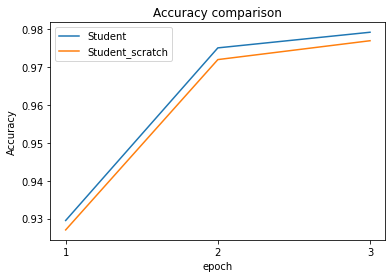

In [14]:
xlabels=range(1,4)
plt.plot(xlabels, student_history.history['sparse_categorical_accuracy'])
plt.plot(xlabels, student_scratch_history.history['sparse_categorical_accuracy'])
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.xticks([1,2,3])
plt.legend(['Student', 'Student_scratch'], loc='upper left')
plt.show()